## Train a sparse semantic unet on patches from vessels gray scale image 

In this notebook we use the patches created in notebook ```21_Make_patches``` (which are generated from the labels in ```15_sparse_label```) as training data for a semantic segmentation unet. 

Imports:  Note on Linux for some reason we have to import and show Napari before importing PyTorch. 

In [1]:
import napari
viewer = napari.Viewer()

import numpy as np
import torch

from tnia.deeplearning.dl_helper import collect_training_data, divide_training_data
from tnia.plotting.plt_helper import imshow_multi2d, random_label_cmap
from semantic_dataset import SemanticDataset
import random
from torch.utils.tensorboard import SummaryWriter
import datetime
from torch.utils.data import DataLoader
from semantic_helper import train
from monai.networks.nets import BasicUNet
from pathlib import Path
import os

raster_geometry not imported.  This is only needed for the ellipsoid rendering in apply_stardist


c:\Users\bnort\miniconda3\envs\microsam_cellpose\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check if Cuda is present

If cuda is not present training will be slow... 

In [2]:
cuda_present = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
use_cuda = cuda_present and ndevices > 0
device = torch.device("cuda" if use_cuda else "cpu")  # "cuda:0" ... default device, "cuda:1" would be GPU index 1, "cuda:2" etc
print("number of devices:", ndevices, "\tchosen device:", device, "\tuse_cuda=", use_cuda)

number of devices: 1 	chosen device: cuda 	use_cuda= True


## Set Parent Path

This is the path that contains the images we will work with and pre-existing patches that would have been created in notebook ```21_Make_patches.ipynb```

In [3]:

#tnia_images_path = Path("/home/bnorthan/images/tnia-python-images")
tnia_images_path = Path(r"D:\images\tnia-python-images")
parent_path = tnia_images_path / r"imagesc/2025_03_31_cellpose_not_precise"

parent_path = tnia_images_path / r"imagesc/2025_04_07_cellpose_not_precise_dense"
sparse = False

train_path = os.path.join(parent_path, 'patches3')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Collect training data

Collect the training data that would have been created in ```33_label_semantic_sparse_rgb.ipynb```

  0%|          | 0/220 [00:00<?, ?it/s]c:\users\bnort\work\imagej2022\tnia\tnia-python\tnia\deeplearning\dl_helper.py:429: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  input_img = io.imread(os.path.join(input_path, input_files[i]), plugin='tifffile')
c:\users\bnort\work\imagej2022\tnia\tnia-python\tnia\deeplearning\dl_helper.py:430: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  ground_truth_img = io.imread(os.path.join(truth_path, truth_files[i]), plugin='tifffile')
c:\users\bnort\work\im

Number of input images 220
Number of ground truth images  220
Size of first input image (256, 256)
Size of first ground truth image  (256, 256)


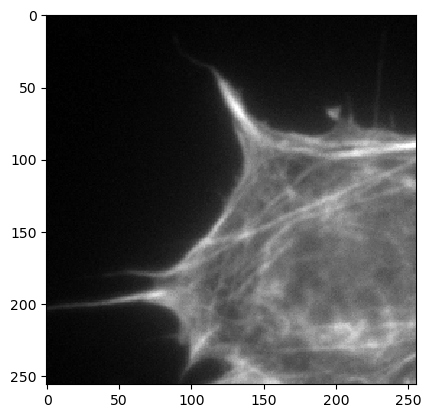

In [4]:
import matplotlib.pyplot as plt

X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel=False, relabel=False)

print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)


plt.imshow(X[2], cmap='gray')

In [5]:
X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, 2, shuffle_data=False, to_numpy=False)

print('Number of training images', len(X_train))
print('Number of validaiton images ', len(X_val))

Number of training images 218
Number of validaiton images  2


In [6]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_val = np.array(X_val)
Y_val = np.array(Y_val)

X_test = X_val
Y_test = Y_val

X_train.shape, Y_train.shape

print('Y_train.max()', Y_train.max())

Y_train.max() 1


In [7]:
if sparse:
    Y_train = Y_train.astype(np.int16)-1
    Y_test = Y_test.astype(np.int16)-1
    Y_val = Y_val.astype(np.int16)-1

In [8]:
print(Y_train.min(), Y_train.max())
print(Y_test.min(), Y_test.max())
print(Y_val.min(), Y_val.max())

0 1
0 1
0 1


## Preview Training Data

Just make sure it looks right and labels correspond to objects properly

uint16
(256, 256) (256, 256)
0.0 1.0
float32 (256, 256) 0.0 1.0


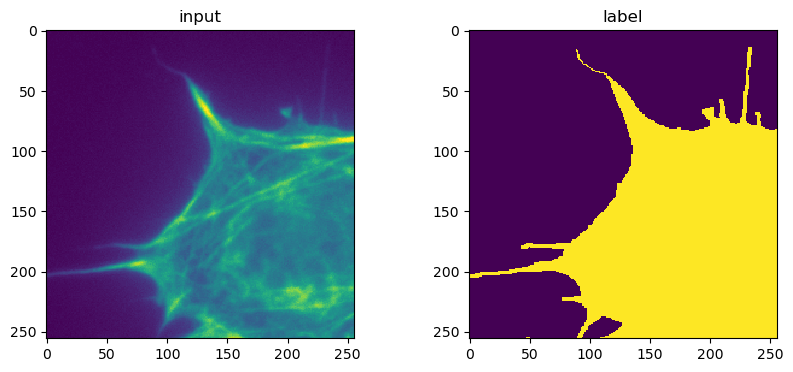

In [9]:
n=0
X_ = X_train[n]
Y_ = Y_train[n]
print(Y_.dtype)

print(X_.shape, Y_.shape)
print(X_.min(), X_.max())
print(X_.dtype, X_.shape, X_.min(), X_.max())
fig=imshow_multi2d([X_, Y_], ['input', 'label'], 1,2)

## Create Datasets

In [10]:
train_dataset = SemanticDataset(X_train, Y_train, crop_size=256)
test_dataset = SemanticDataset(X_val, Y_val, crop_size=256)
val_dataset = SemanticDataset(X_val, Y_val, crop_size=256)

# verify that the dataset is working
raw, mask = train_dataset[random.randrange(len(train_dataset))]
raw = np.transpose(raw, (1,2,0))
raw.shape,mask.shape

((256, 256, 1), (1, 256, 256))

## Visualize a few datasets

0 1
0.42340087890625
0 1
0.651611328125
0 1
0.4588623046875


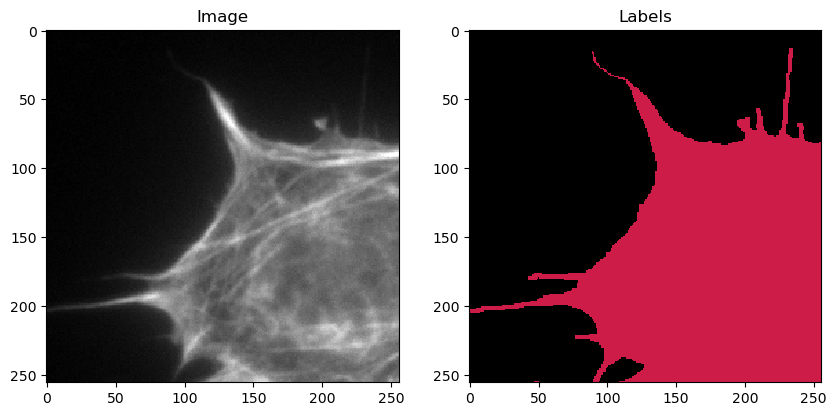

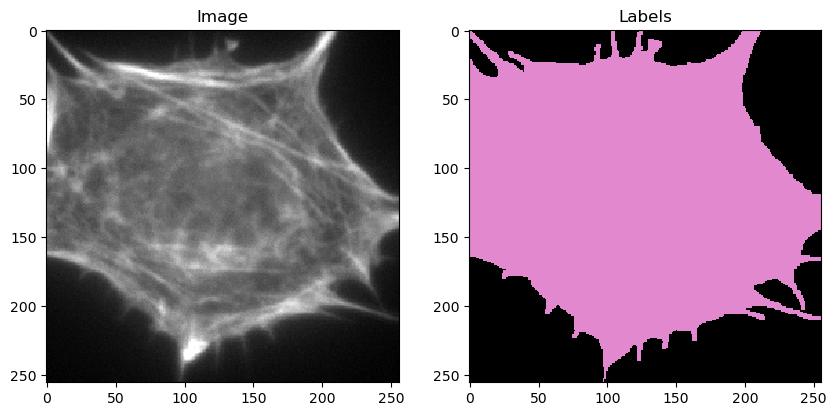

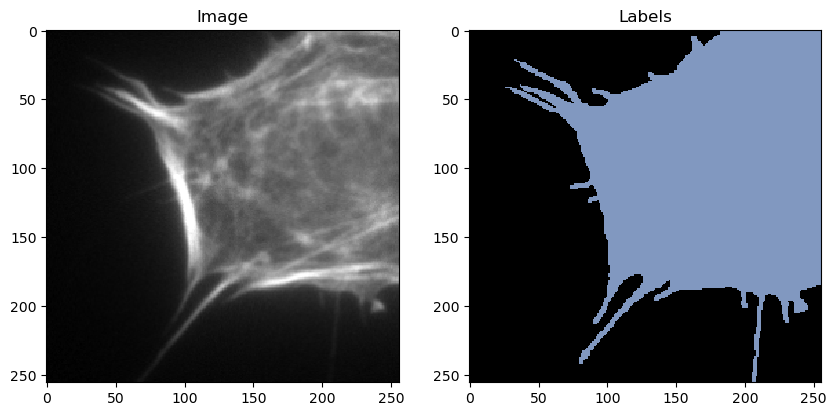

In [11]:
raw, mask = train_dataset[0]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())
print(mask[mask==1].size/mask.size)    

raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())
print(mask[mask==1].size/mask.size)    

raw, mask = train_dataset[10]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())
print(mask[mask==1].size/mask.size)    

## Set up unet

We use monai BasicUnet.

Since image is RGB in_channels are 3

Since the dataset we are working with has 3 classes, out_channels are 3

No activation function since we are using CrossEntropyLoss which applies softmax
Note: predictor will need to use a softmax activation function



In [12]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1)
loss_fn = torch.nn.CrossEntropyLoss()
dtype = torch.LongTensor

net = BasicUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    #features=[16, 16, 32, 64, 128, 16],
    act=None,
    norm="batch",
    #norm=None,
    #dropout=0.25,
)

#net = torch.load( Path(model_path) / 'model_march22.pth')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
loss_fn = loss_fn.to(device)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

BasicUNet features: (32, 32, 64, 128, 256, 32).


## Start training process

In [13]:
train_batch_size =32 
test_batch_size = 1

learning_rate = 5e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# make dataloaders
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, pin_memory=True, shuffle=True)
check_loader = DataLoader(train_dataset, batch_size=train_batch_size, pin_memory=True, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size)

In [14]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="runs/experiment_name")  # Change name as needed

current_epoch = 0

In [26]:

%load_ext tensorboard
%tensorboard --logdir=runs

In [15]:
training_steps = 500

num_epochs=400

train(train_loader, val_loader, net, loss_fn, optimizer, dtype, num_epochs, device, writer=writer, current_epoch=current_epoch)
current_epoch += num_epochs
#test_data_loader(train_loader, val_loader, net2, loss_fn, optimizer, dtype, 1, 100, device, writer)
#train(train_loader, val_loader, net2, loss_fn, None, optimizer, dtype, 10, device, writer)


torch.save(net, Path(model_path) / 'model_April09_big.pth')

Epoch 0: 100%|██████████| 218/218 [00:01<00:00, 133.66it/s]


training loss at epoch 0 is 0.008668380387879293


Epoch 1: 100%|██████████| 218/218 [00:00<00:00, 250.02it/s]


training loss at epoch 1 is 0.0031189469090842324


Epoch 2: 100%|██████████| 218/218 [00:00<00:00, 237.19it/s]


training loss at epoch 2 is 0.0026852665896262597


Epoch 3: 100%|██████████| 218/218 [00:00<00:00, 229.47it/s]


training loss at epoch 3 is 0.0024548178077290913


Epoch 4: 100%|██████████| 218/218 [00:00<00:00, 223.05it/s]


training loss at epoch 4 is 0.002297500643981706


Epoch 5: 100%|██████████| 218/218 [00:01<00:00, 199.62it/s]


training loss at epoch 5 is 0.002177427463028409


Epoch 6: 100%|██████████| 218/218 [00:01<00:00, 201.08it/s]


training loss at epoch 6 is 0.0020841969467631175


Epoch 7: 100%|██████████| 218/218 [00:00<00:00, 233.91it/s]


training loss at epoch 7 is 0.0020149514557571586


Epoch 8: 100%|██████████| 218/218 [00:00<00:00, 220.65it/s]


training loss at epoch 8 is 0.0019290978003532514


Epoch 9: 100%|██████████| 218/218 [00:01<00:00, 177.38it/s]


training loss at epoch 9 is 0.0018504844517062563


Epoch 10: 100%|██████████| 218/218 [00:01<00:00, 211.24it/s]


training loss at epoch 10 is 0.0018016502021922978


Epoch 11: 100%|██████████| 218/218 [00:00<00:00, 231.02it/s]


training loss at epoch 11 is 0.0017425009143461874


Epoch 12: 100%|██████████| 218/218 [00:01<00:00, 216.06it/s]


training loss at epoch 12 is 0.0016732542100576086


Epoch 13: 100%|██████████| 218/218 [00:00<00:00, 231.18it/s]


training loss at epoch 13 is 0.0016387567402572807


Epoch 14: 100%|██████████| 218/218 [00:01<00:00, 206.58it/s]


training loss at epoch 14 is 0.001642630563690028


Epoch 15: 100%|██████████| 218/218 [00:00<00:00, 228.95it/s]


training loss at epoch 15 is 0.0015945258046235512


Epoch 16: 100%|██████████| 218/218 [00:01<00:00, 192.41it/s]


training loss at epoch 16 is 0.0015256438882799324


Epoch 17: 100%|██████████| 218/218 [00:01<00:00, 175.00it/s]


training loss at epoch 17 is 0.0014816313947832913


Epoch 18: 100%|██████████| 218/218 [00:01<00:00, 209.97it/s]


training loss at epoch 18 is 0.0014383780402601313


Epoch 19: 100%|██████████| 218/218 [00:00<00:00, 228.44it/s]


training loss at epoch 19 is 0.0014115645456204721


Epoch 20: 100%|██████████| 218/218 [00:00<00:00, 228.75it/s]


training loss at epoch 20 is 0.0013557779987197404


Epoch 21: 100%|██████████| 218/218 [00:00<00:00, 228.99it/s]


training loss at epoch 21 is 0.0013578801902882549


Epoch 22: 100%|██████████| 218/218 [00:00<00:00, 226.85it/s]


training loss at epoch 22 is 0.0013261963399725223


Epoch 23: 100%|██████████| 218/218 [00:00<00:00, 227.80it/s]


training loss at epoch 23 is 0.0012941718477448192


Epoch 24: 100%|██████████| 218/218 [00:00<00:00, 226.59it/s]


training loss at epoch 24 is 0.001249316943074585


Epoch 25: 100%|██████████| 218/218 [00:01<00:00, 217.61it/s]


training loss at epoch 25 is 0.0012294974929969245


Epoch 26: 100%|██████████| 218/218 [00:00<00:00, 226.38it/s]


training loss at epoch 26 is 0.0012056362054763583


Epoch 27: 100%|██████████| 218/218 [00:00<00:00, 223.45it/s]


training loss at epoch 27 is 0.0011980293677487505


Epoch 28: 100%|██████████| 218/218 [00:00<00:00, 228.26it/s]


training loss at epoch 28 is 0.0011484770599855196


Epoch 29: 100%|██████████| 218/218 [00:00<00:00, 234.66it/s]


training loss at epoch 29 is 0.0011306597312929433


Epoch 30: 100%|██████████| 218/218 [00:01<00:00, 177.45it/s]


training loss at epoch 30 is 0.0010997417357263214


Epoch 31: 100%|██████████| 218/218 [00:01<00:00, 197.73it/s]


training loss at epoch 31 is 0.0010775998747403468


Epoch 32: 100%|██████████| 218/218 [00:00<00:00, 220.82it/s]


training loss at epoch 32 is 0.0010549904727334277


Epoch 33: 100%|██████████| 218/218 [00:00<00:00, 230.12it/s]


training loss at epoch 33 is 0.0010363899444768188


Epoch 34: 100%|██████████| 218/218 [00:01<00:00, 215.42it/s]


training loss at epoch 34 is 0.0010130125260271064


Epoch 35: 100%|██████████| 218/218 [00:01<00:00, 212.68it/s]


training loss at epoch 35 is 0.001023994416955414


Epoch 36: 100%|██████████| 218/218 [00:00<00:00, 236.96it/s]


training loss at epoch 36 is 0.000978719024414863


Epoch 37: 100%|██████████| 218/218 [00:01<00:00, 215.30it/s]


training loss at epoch 37 is 0.0009508917467036379


Epoch 38: 100%|██████████| 218/218 [00:00<00:00, 228.00it/s]


training loss at epoch 38 is 0.0009398751148800237


Epoch 39: 100%|██████████| 218/218 [00:00<00:00, 219.34it/s]


training loss at epoch 39 is 0.0009169741576417871


Epoch 40: 100%|██████████| 218/218 [00:00<00:00, 235.42it/s]


training loss at epoch 40 is 0.0008854926862847915


Epoch 41: 100%|██████████| 218/218 [00:00<00:00, 239.30it/s]


training loss at epoch 41 is 0.0008822059549322916


Epoch 42: 100%|██████████| 218/218 [00:01<00:00, 203.55it/s]


training loss at epoch 42 is 0.0008890850965036165


Epoch 43: 100%|██████████| 218/218 [00:00<00:00, 232.81it/s]


training loss at epoch 43 is 0.0008729008718504818


Epoch 44: 100%|██████████| 218/218 [00:01<00:00, 210.04it/s]


training loss at epoch 44 is 0.0008476329796494694


Epoch 45: 100%|██████████| 218/218 [00:01<00:00, 191.98it/s]


training loss at epoch 45 is 0.0008151354609962998


Epoch 46: 100%|██████████| 218/218 [00:01<00:00, 214.57it/s]


training loss at epoch 46 is 0.0008175987750291824


Epoch 47: 100%|██████████| 218/218 [00:00<00:00, 227.25it/s]


training loss at epoch 47 is 0.0008009949938283054


Epoch 48: 100%|██████████| 218/218 [00:00<00:00, 218.77it/s]


training loss at epoch 48 is 0.0007929135746228585


Epoch 49: 100%|██████████| 218/218 [00:00<00:00, 230.53it/s]


training loss at epoch 49 is 0.0007840736914391911


Epoch 50: 100%|██████████| 218/218 [00:00<00:00, 234.66it/s]


training loss at epoch 50 is 0.0007578130179178824


Epoch 51: 100%|██████████| 218/218 [00:01<00:00, 210.37it/s]


training loss at epoch 51 is 0.0007285822114539803


Epoch 52: 100%|██████████| 218/218 [00:00<00:00, 239.82it/s]


training loss at epoch 52 is 0.0007074774935021313


Epoch 53: 100%|██████████| 218/218 [00:01<00:00, 217.00it/s]


training loss at epoch 53 is 0.0007225778295632897


Epoch 54: 100%|██████████| 218/218 [00:00<00:00, 227.32it/s]


training loss at epoch 54 is 0.0007038484626543631


Epoch 55: 100%|██████████| 218/218 [00:00<00:00, 224.96it/s]


training loss at epoch 55 is 0.0006726899209919325


Epoch 56: 100%|██████████| 218/218 [00:01<00:00, 217.45it/s]


training loss at epoch 56 is 0.0006606512352687503


Epoch 57: 100%|██████████| 218/218 [00:00<00:00, 220.91it/s]


training loss at epoch 57 is 0.0006484410323954504


Epoch 58: 100%|██████████| 218/218 [00:01<00:00, 200.26it/s]


training loss at epoch 58 is 0.0006509208880843372


Epoch 59: 100%|██████████| 218/218 [00:01<00:00, 215.77it/s]


training loss at epoch 59 is 0.0006274829422115186


Epoch 60: 100%|██████████| 218/218 [00:00<00:00, 234.66it/s]


training loss at epoch 60 is 0.0006154902074315133


Epoch 61: 100%|██████████| 218/218 [00:00<00:00, 218.66it/s]


training loss at epoch 61 is 0.000614559875989179


Epoch 62: 100%|██████████| 218/218 [00:00<00:00, 230.44it/s]


training loss at epoch 62 is 0.0006176344281352988


Epoch 63: 100%|██████████| 218/218 [00:00<00:00, 239.54it/s]


training loss at epoch 63 is 0.0006124513104147867


Epoch 64: 100%|██████████| 218/218 [00:00<00:00, 240.64it/s]


training loss at epoch 64 is 0.0006018848833414393


Epoch 65: 100%|██████████| 218/218 [00:00<00:00, 243.58it/s]


training loss at epoch 65 is 0.0005854004823149891


Epoch 66: 100%|██████████| 218/218 [00:00<00:00, 229.96it/s]


training loss at epoch 66 is 0.0005736871528516121


Epoch 67: 100%|██████████| 218/218 [00:00<00:00, 236.44it/s]


training loss at epoch 67 is 0.0005776088411381486


Epoch 68: 100%|██████████| 218/218 [00:01<00:00, 215.61it/s]


training loss at epoch 68 is 0.0005651109962971933


Epoch 69: 100%|██████████| 218/218 [00:00<00:00, 224.51it/s]


training loss at epoch 69 is 0.0005698337672500435


Epoch 70: 100%|██████████| 218/218 [00:00<00:00, 234.41it/s]


training loss at epoch 70 is 0.0005552344400128093


Epoch 71: 100%|██████████| 218/218 [00:00<00:00, 238.25it/s]


training loss at epoch 71 is 0.0005476865404789601


Epoch 72: 100%|██████████| 218/218 [00:00<00:00, 241.13it/s]


training loss at epoch 72 is 0.0005369772707377005


Epoch 73: 100%|██████████| 218/218 [00:00<00:00, 231.67it/s]


training loss at epoch 73 is 0.0005449362252967073


Epoch 74: 100%|██████████| 218/218 [00:00<00:00, 235.42it/s]


training loss at epoch 74 is 0.0005258169247333063


Epoch 75: 100%|██████████| 218/218 [00:00<00:00, 236.70it/s]


training loss at epoch 75 is 0.0005155982697433835


Epoch 76: 100%|██████████| 218/218 [00:01<00:00, 216.70it/s]


training loss at epoch 76 is 0.0005037696869753369


Epoch 77: 100%|██████████| 218/218 [00:00<00:00, 234.62it/s]


training loss at epoch 77 is 0.0004975913827298978


Epoch 78: 100%|██████████| 218/218 [00:00<00:00, 235.68it/s]


training loss at epoch 78 is 0.0004953714984751075


Epoch 79: 100%|██████████| 218/218 [00:00<00:00, 227.50it/s]


training loss at epoch 79 is 0.0004869288756349765


Epoch 80: 100%|██████████| 218/218 [00:00<00:00, 227.17it/s]


training loss at epoch 80 is 0.0004704915192149101


Epoch 81: 100%|██████████| 218/218 [00:00<00:00, 224.49it/s]


training loss at epoch 81 is 0.0004614879924017902


Epoch 82: 100%|██████████| 218/218 [00:00<00:00, 239.30it/s]


training loss at epoch 82 is 0.0004482708204913577


Epoch 83: 100%|██████████| 218/218 [00:00<00:00, 235.14it/s]


training loss at epoch 83 is 0.0004400665436042558


Epoch 84: 100%|██████████| 218/218 [00:00<00:00, 233.66it/s]


training loss at epoch 84 is 0.00043525824477092933


Epoch 85: 100%|██████████| 218/218 [00:00<00:00, 235.42it/s]


training loss at epoch 85 is 0.0004314842693712733


Epoch 86: 100%|██████████| 218/218 [00:00<00:00, 228.51it/s]


training loss at epoch 86 is 0.00043268849082086065


Epoch 87: 100%|██████████| 218/218 [00:00<00:00, 240.35it/s]


training loss at epoch 87 is 0.00044486831890743807


Epoch 88: 100%|██████████| 218/218 [00:00<00:00, 232.91it/s]


training loss at epoch 88 is 0.00042039849325467684


Epoch 89: 100%|██████████| 218/218 [00:00<00:00, 236.19it/s]


training loss at epoch 89 is 0.0004171390735774959


Epoch 90: 100%|██████████| 218/218 [00:00<00:00, 240.09it/s]


training loss at epoch 90 is 0.0004091741893132892


Epoch 91: 100%|██████████| 218/218 [00:01<00:00, 211.45it/s]


training loss at epoch 91 is 0.0004114414898490687


Epoch 92: 100%|██████████| 218/218 [00:01<00:00, 209.62it/s]


training loss at epoch 92 is 0.000398050600645739


Epoch 93: 100%|██████████| 218/218 [00:00<00:00, 235.17it/s]


training loss at epoch 93 is 0.0003818364326901939


Epoch 94: 100%|██████████| 218/218 [00:00<00:00, 241.69it/s]


training loss at epoch 94 is 0.00038339520608066417


Epoch 95: 100%|██████████| 218/218 [00:00<00:00, 226.38it/s]


training loss at epoch 95 is 0.0003895709000596213


Epoch 96: 100%|██████████| 218/218 [00:00<00:00, 223.59it/s]


training loss at epoch 96 is 0.00038179328425898463


Epoch 97: 100%|██████████| 218/218 [00:00<00:00, 243.03it/s]


training loss at epoch 97 is 0.000385715408301955


Epoch 98: 100%|██████████| 218/218 [00:00<00:00, 230.44it/s]


training loss at epoch 98 is 0.00039066923269574793


Epoch 99: 100%|██████████| 218/218 [00:00<00:00, 237.21it/s]


training loss at epoch 99 is 0.0003847522797797798


Epoch 100: 100%|██████████| 218/218 [00:00<00:00, 226.85it/s]


training loss at epoch 100 is 0.00038891660750185676


Epoch 101: 100%|██████████| 218/218 [00:01<00:00, 214.34it/s]


training loss at epoch 101 is 0.0003846683838498702


Epoch 102: 100%|██████████| 218/218 [00:01<00:00, 217.55it/s]


training loss at epoch 102 is 0.00037372497192353284


Epoch 103: 100%|██████████| 218/218 [00:00<00:00, 239.58it/s]


training loss at epoch 103 is 0.0003579829118872454


Epoch 104: 100%|██████████| 218/218 [00:00<00:00, 241.68it/s]


training loss at epoch 104 is 0.00036242910139604444


Epoch 105: 100%|██████████| 218/218 [00:00<00:00, 218.65it/s]


training loss at epoch 105 is 0.00035999124066545327


Epoch 106: 100%|██████████| 218/218 [00:00<00:00, 234.92it/s]


training loss at epoch 106 is 0.00036935033618446883


Epoch 107: 100%|██████████| 218/218 [00:00<00:00, 224.05it/s]


training loss at epoch 107 is 0.0003709229085286823


Epoch 108: 100%|██████████| 218/218 [00:01<00:00, 210.41it/s]


training loss at epoch 108 is 0.00036462763785769084


Epoch 109: 100%|██████████| 218/218 [00:01<00:00, 208.41it/s]


training loss at epoch 109 is 0.00036074122875382045


Epoch 110: 100%|██████████| 218/218 [00:00<00:00, 238.25it/s]


training loss at epoch 110 is 0.0003556276056402867


Epoch 111: 100%|██████████| 218/218 [00:00<00:00, 232.66it/s]


training loss at epoch 111 is 0.000341483455903213


Epoch 112: 100%|██████████| 218/218 [00:00<00:00, 239.56it/s]


training loss at epoch 112 is 0.00034222770225974397


Epoch 113: 100%|██████████| 218/218 [00:00<00:00, 220.85it/s]


training loss at epoch 113 is 0.0003372340787783128


Epoch 114: 100%|██████████| 218/218 [00:00<00:00, 240.88it/s]


training loss at epoch 114 is 0.00032724956170134586


Epoch 115: 100%|██████████| 218/218 [00:00<00:00, 240.35it/s]


training loss at epoch 115 is 0.0003262496843865705


Epoch 116: 100%|██████████| 218/218 [00:00<00:00, 238.51it/s]


training loss at epoch 116 is 0.0003245249262438455


Epoch 117: 100%|██████████| 218/218 [00:00<00:00, 240.09it/s]


training loss at epoch 117 is 0.00031684204474638364


Epoch 118: 100%|██████████| 218/218 [00:00<00:00, 239.30it/s]


training loss at epoch 118 is 0.0003124668963526914


Epoch 119: 100%|██████████| 218/218 [00:00<00:00, 238.77it/s]


training loss at epoch 119 is 0.0002996122268020013


Epoch 120: 100%|██████████| 218/218 [00:00<00:00, 237.99it/s]


training loss at epoch 120 is 0.00030113133781273433


Epoch 121: 100%|██████████| 218/218 [00:00<00:00, 235.42it/s]


training loss at epoch 121 is 0.0003020689190459361


Epoch 122: 100%|██████████| 218/218 [00:00<00:00, 235.68it/s]


training loss at epoch 122 is 0.00031058632537996


Epoch 123: 100%|██████████| 218/218 [00:00<00:00, 229.47it/s]


training loss at epoch 123 is 0.00031097664779752767


Epoch 124: 100%|██████████| 218/218 [00:00<00:00, 242.74it/s]


training loss at epoch 124 is 0.0002931853747764312


Epoch 125: 100%|██████████| 218/218 [00:00<00:00, 227.56it/s]


training loss at epoch 125 is 0.00029190876222121606


Epoch 126: 100%|██████████| 218/218 [00:00<00:00, 239.04it/s]


training loss at epoch 126 is 0.0003037877944768022


Epoch 127: 100%|██████████| 218/218 [00:00<00:00, 237.99it/s]


training loss at epoch 127 is 0.0002904322741706984


Epoch 128: 100%|██████████| 218/218 [00:01<00:00, 213.52it/s]


training loss at epoch 128 is 0.00028463814903153194


Epoch 129: 100%|██████████| 218/218 [00:00<00:00, 225.67it/s]


training loss at epoch 129 is 0.00028830830332472783


Epoch 130: 100%|██████████| 218/218 [00:00<00:00, 239.04it/s]


training loss at epoch 130 is 0.0002887295900818405


Epoch 131: 100%|██████████| 218/218 [00:00<00:00, 218.22it/s]


training loss at epoch 131 is 0.00027941154538218036


Epoch 132: 100%|██████████| 218/218 [00:00<00:00, 220.42it/s]


training loss at epoch 132 is 0.0002717452397176979


Epoch 133: 100%|██████████| 218/218 [00:00<00:00, 230.93it/s]


training loss at epoch 133 is 0.0002704002475793209


Epoch 134: 100%|██████████| 218/218 [00:00<00:00, 242.22it/s]


training loss at epoch 134 is 0.00029224042413294863


Epoch 135: 100%|██████████| 218/218 [00:00<00:00, 226.85it/s]


training loss at epoch 135 is 0.00029772153090036244


Epoch 136: 100%|██████████| 218/218 [00:00<00:00, 227.44it/s]


training loss at epoch 136 is 0.0002954139143501947


Epoch 137: 100%|██████████| 218/218 [00:00<00:00, 240.62it/s]


training loss at epoch 137 is 0.00028166579885767143


Epoch 138: 100%|██████████| 218/218 [00:00<00:00, 235.42it/s]


training loss at epoch 138 is 0.00027891864931774797


Epoch 139: 100%|██████████| 218/218 [00:00<00:00, 226.02it/s]


training loss at epoch 139 is 0.0002965275710875835


Epoch 140: 100%|██████████| 218/218 [00:00<00:00, 238.25it/s]


training loss at epoch 140 is 0.00028015891038769977


Epoch 141: 100%|██████████| 218/218 [00:00<00:00, 226.96it/s]


training loss at epoch 141 is 0.00026551984814465594


Epoch 142: 100%|██████████| 218/218 [00:01<00:00, 217.02it/s]


training loss at epoch 142 is 0.0002579803454664049


Epoch 143: 100%|██████████| 218/218 [00:00<00:00, 233.16it/s]


training loss at epoch 143 is 0.0002471393320299343


Epoch 144: 100%|██████████| 218/218 [00:00<00:00, 240.47it/s]


training loss at epoch 144 is 0.00024065444963650967


Epoch 145: 100%|██████████| 218/218 [00:00<00:00, 227.08it/s]


training loss at epoch 145 is 0.00024133092732331075


Epoch 146: 100%|██████████| 218/218 [00:00<00:00, 237.45it/s]


training loss at epoch 146 is 0.00023823647563337187


Epoch 147: 100%|██████████| 218/218 [00:00<00:00, 230.44it/s]


training loss at epoch 147 is 0.00023817474133582838


Epoch 148: 100%|██████████| 218/218 [00:00<00:00, 239.56it/s]


training loss at epoch 148 is 0.0002268499442709422


Epoch 149: 100%|██████████| 218/218 [00:00<00:00, 238.25it/s]


training loss at epoch 149 is 0.0002225282401222428


Epoch 150: 100%|██████████| 218/218 [00:00<00:00, 230.94it/s]


training loss at epoch 150 is 0.00022366789699352661


Epoch 151: 100%|██████████| 218/218 [00:00<00:00, 230.69it/s]


training loss at epoch 151 is 0.00021760254765117388


Epoch 152: 100%|██████████| 218/218 [00:00<00:00, 225.74it/s]


training loss at epoch 152 is 0.00020863703631479805


Epoch 153: 100%|██████████| 218/218 [00:01<00:00, 202.23it/s]


training loss at epoch 153 is 0.00020621615726876697


Epoch 154: 100%|██████████| 218/218 [00:00<00:00, 224.51it/s]


training loss at epoch 154 is 0.00020734429436334228


Epoch 155: 100%|██████████| 218/218 [00:00<00:00, 236.70it/s]


training loss at epoch 155 is 0.00020274274914158048


Epoch 156: 100%|██████████| 218/218 [00:00<00:00, 219.32it/s]


training loss at epoch 156 is 0.00020771576177089587


Epoch 157: 100%|██████████| 218/218 [00:01<00:00, 202.79it/s]


training loss at epoch 157 is 0.00020668280968835594


Epoch 158: 100%|██████████| 218/218 [00:00<00:00, 221.77it/s]


training loss at epoch 158 is 0.00020976950106886002


Epoch 159: 100%|██████████| 218/218 [00:00<00:00, 231.42it/s]


training loss at epoch 159 is 0.00020726331842875262


Epoch 160: 100%|██████████| 218/218 [00:00<00:00, 220.27it/s]


training loss at epoch 160 is 0.0002062047229344965


Epoch 161: 100%|██████████| 218/218 [00:00<00:00, 225.94it/s]


training loss at epoch 161 is 0.00020318783588980864


Epoch 162: 100%|██████████| 218/218 [00:00<00:00, 224.85it/s]


training loss at epoch 162 is 0.00020892804044239018


Epoch 163: 100%|██████████| 218/218 [00:00<00:00, 237.99it/s]


training loss at epoch 163 is 0.00020540001110062688


Epoch 164: 100%|██████████| 218/218 [00:00<00:00, 228.99it/s]


training loss at epoch 164 is 0.00019861772494100103


Epoch 165: 100%|██████████| 218/218 [00:00<00:00, 238.11it/s]


training loss at epoch 165 is 0.00020009370888113428


Epoch 166: 100%|██████████| 218/218 [00:00<00:00, 239.82it/s]


training loss at epoch 166 is 0.00022241936082345083


Epoch 167: 100%|██████████| 218/218 [00:00<00:00, 237.48it/s]


training loss at epoch 167 is 0.00021245631543116285


Epoch 168: 100%|██████████| 218/218 [00:00<00:00, 236.44it/s]


training loss at epoch 168 is 0.00023104507185587095


Epoch 169: 100%|██████████| 218/218 [00:00<00:00, 229.96it/s]


training loss at epoch 169 is 0.0002259812958606886


Epoch 170: 100%|██████████| 218/218 [00:00<00:00, 225.24it/s]


training loss at epoch 170 is 0.00023090514704721783


Epoch 171: 100%|██████████| 218/218 [00:00<00:00, 241.15it/s]


training loss at epoch 171 is 0.0002212871737573125


Epoch 172: 100%|██████████| 218/218 [00:00<00:00, 238.22it/s]


training loss at epoch 172 is 0.0002157891472511062


Epoch 173: 100%|██████████| 218/218 [00:00<00:00, 237.22it/s]


training loss at epoch 173 is 0.00022319783969278182


Epoch 174: 100%|██████████| 218/218 [00:00<00:00, 237.21it/s]


training loss at epoch 174 is 0.00022252767193002985


Epoch 175: 100%|██████████| 218/218 [00:00<00:00, 237.73it/s]


training loss at epoch 175 is 0.0002194535619485269


Epoch 176: 100%|██████████| 218/218 [00:00<00:00, 237.47it/s]


training loss at epoch 176 is 0.0002034011258478832


Epoch 177: 100%|██████████| 218/218 [00:00<00:00, 237.73it/s]


training loss at epoch 177 is 0.0001938735015280203


Epoch 178: 100%|██████████| 218/218 [00:00<00:00, 237.73it/s]


training loss at epoch 178 is 0.00019193933678602953


Epoch 179: 100%|██████████| 218/218 [00:00<00:00, 236.96it/s]


training loss at epoch 179 is 0.0001865057936878106


Epoch 180: 100%|██████████| 218/218 [00:00<00:00, 241.13it/s]


training loss at epoch 180 is 0.00018284914998012945


Epoch 181: 100%|██████████| 218/218 [00:00<00:00, 237.47it/s]


training loss at epoch 181 is 0.00018712216261945186


Epoch 182: 100%|██████████| 218/218 [00:00<00:00, 238.04it/s]


training loss at epoch 182 is 0.00018415526580919914


Epoch 183: 100%|██████████| 218/218 [00:00<00:00, 236.98it/s]


training loss at epoch 183 is 0.00019977576902495064


Epoch 184: 100%|██████████| 218/218 [00:00<00:00, 236.96it/s]


training loss at epoch 184 is 0.0002007086786928527


Epoch 185: 100%|██████████| 218/218 [00:00<00:00, 232.28it/s]


training loss at epoch 185 is 0.00020052084844525254


Epoch 186: 100%|██████████| 218/218 [00:00<00:00, 227.67it/s]


training loss at epoch 186 is 0.00019013519834624518


Epoch 187: 100%|██████████| 218/218 [00:00<00:00, 220.81it/s]


training loss at epoch 187 is 0.00017710889629814604


Epoch 188: 100%|██████████| 218/218 [00:00<00:00, 228.30it/s]


training loss at epoch 188 is 0.0001774649498898775


Epoch 189: 100%|██████████| 218/218 [00:00<00:00, 228.99it/s]


training loss at epoch 189 is 0.00017401306044071094


Epoch 190: 100%|██████████| 218/218 [00:00<00:00, 237.99it/s]


training loss at epoch 190 is 0.0001731721039246255


Epoch 191: 100%|██████████| 218/218 [00:00<00:00, 237.15it/s]


training loss at epoch 191 is 0.00018125162630794792


Epoch 192: 100%|██████████| 218/218 [00:00<00:00, 237.45it/s]


training loss at epoch 192 is 0.00017472442427496297


Epoch 193: 100%|██████████| 218/218 [00:00<00:00, 239.56it/s]


training loss at epoch 193 is 0.00016502987960814882


Epoch 194: 100%|██████████| 218/218 [00:00<00:00, 236.70it/s]


training loss at epoch 194 is 0.0001680883493513689


Epoch 195: 100%|██████████| 218/218 [00:00<00:00, 237.73it/s]


training loss at epoch 195 is 0.00016138779529190937


Epoch 196: 100%|██████████| 218/218 [00:00<00:00, 235.42it/s]


training loss at epoch 196 is 0.00015868846361243396


Epoch 197: 100%|██████████| 218/218 [00:00<00:00, 237.99it/s]


training loss at epoch 197 is 0.00015789953940505282


Epoch 198: 100%|██████████| 218/218 [00:00<00:00, 229.83it/s]


training loss at epoch 198 is 0.00015722735947288504


Epoch 199: 100%|██████████| 218/218 [00:00<00:00, 233.78it/s]


training loss at epoch 199 is 0.00015864379430582763


Epoch 200: 100%|██████████| 218/218 [00:00<00:00, 219.71it/s]


training loss at epoch 200 is 0.00017013807926292813


Epoch 201: 100%|██████████| 218/218 [00:00<00:00, 236.56it/s]


training loss at epoch 201 is 0.00016413016005530269


Epoch 202: 100%|██████████| 218/218 [00:00<00:00, 222.96it/s]


training loss at epoch 202 is 0.00016534318207600795


Epoch 203: 100%|██████████| 218/218 [00:00<00:00, 226.03it/s]


training loss at epoch 203 is 0.00015770732382432037


Epoch 204: 100%|██████████| 218/218 [00:00<00:00, 233.78it/s]


training loss at epoch 204 is 0.0001562047907826277


Epoch 205: 100%|██████████| 218/218 [00:00<00:00, 233.91it/s]


training loss at epoch 205 is 0.00015500367943778497


Epoch 206: 100%|██████████| 218/218 [00:00<00:00, 235.01it/s]


training loss at epoch 206 is 0.00015055725069015944


Epoch 207: 100%|██████████| 218/218 [00:00<00:00, 238.25it/s]


training loss at epoch 207 is 0.00014714933632779012


Epoch 208: 100%|██████████| 218/218 [00:00<00:00, 221.54it/s]


training loss at epoch 208 is 0.0001439020387965058


Epoch 209: 100%|██████████| 218/218 [00:00<00:00, 222.68it/s]


training loss at epoch 209 is 0.0001446771811386314


Epoch 210: 100%|██████████| 218/218 [00:00<00:00, 239.82it/s]


training loss at epoch 210 is 0.00014991486880825748


Epoch 211: 100%|██████████| 218/218 [00:00<00:00, 232.81it/s]


training loss at epoch 211 is 0.00014893599324475188


Epoch 212: 100%|██████████| 218/218 [00:00<00:00, 231.00it/s]


training loss at epoch 212 is 0.0001487788902339312


Epoch 213: 100%|██████████| 218/218 [00:00<00:00, 227.76it/s]


training loss at epoch 213 is 0.000147745122176108


Epoch 214: 100%|██████████| 218/218 [00:00<00:00, 235.93it/s]


training loss at epoch 214 is 0.00014901302387476515


Epoch 215: 100%|██████████| 218/218 [00:00<00:00, 235.68it/s]


training loss at epoch 215 is 0.00014930172532865213


Epoch 216: 100%|██████████| 218/218 [00:00<00:00, 235.42it/s]


training loss at epoch 216 is 0.0001466701516386019


Epoch 217: 100%|██████████| 218/218 [00:00<00:00, 236.95it/s]


training loss at epoch 217 is 0.00014476735495167587


Epoch 218: 100%|██████████| 218/218 [00:00<00:00, 234.16it/s]


training loss at epoch 218 is 0.00014841250024325803


Epoch 219: 100%|██████████| 218/218 [00:00<00:00, 239.82it/s]


training loss at epoch 219 is 0.0001650763496141368


Epoch 220: 100%|██████████| 218/218 [00:00<00:00, 223.59it/s]


training loss at epoch 220 is 0.00016291259676901572


Epoch 221: 100%|██████████| 218/218 [00:00<00:00, 230.33it/s]


training loss at epoch 221 is 0.0001675538022344539


Epoch 222: 100%|██████████| 218/218 [00:00<00:00, 228.51it/s]


training loss at epoch 222 is 0.00015795109750822597


Epoch 223: 100%|██████████| 218/218 [00:00<00:00, 234.66it/s]


training loss at epoch 223 is 0.0001489788511716718


Epoch 224: 100%|██████████| 218/218 [00:00<00:00, 240.13it/s]


training loss at epoch 224 is 0.00014824102581435935


Epoch 225: 100%|██████████| 218/218 [00:00<00:00, 220.37it/s]


training loss at epoch 225 is 0.0001402144328853406


Epoch 226: 100%|██████████| 218/218 [00:00<00:00, 222.51it/s]


training loss at epoch 226 is 0.00013696394835111745


Epoch 227: 100%|██████████| 218/218 [00:00<00:00, 226.14it/s]


training loss at epoch 227 is 0.0001329932566903053


Epoch 228: 100%|██████████| 218/218 [00:01<00:00, 212.15it/s]


training loss at epoch 228 is 0.00013583996803115267


Epoch 229: 100%|██████████| 218/218 [00:00<00:00, 228.96it/s]


training loss at epoch 229 is 0.00013284063086323782


Epoch 230: 100%|██████████| 218/218 [00:00<00:00, 219.10it/s]


training loss at epoch 230 is 0.0001288727160816619


Epoch 231: 100%|██████████| 218/218 [00:00<00:00, 242.62it/s]


training loss at epoch 231 is 0.00012392104697336845


Epoch 232: 100%|██████████| 218/218 [00:00<00:00, 222.68it/s]


training loss at epoch 232 is 0.00012425577626862656


Epoch 233: 100%|██████████| 218/218 [00:00<00:00, 235.93it/s]


training loss at epoch 233 is 0.0001272929729808361


Epoch 234: 100%|██████████| 218/218 [00:00<00:00, 243.30it/s]


training loss at epoch 234 is 0.0001314949669336917


Epoch 235: 100%|██████████| 218/218 [00:00<00:00, 222.45it/s]


training loss at epoch 235 is 0.0001302380360440787


Epoch 236: 100%|██████████| 218/218 [00:00<00:00, 238.77it/s]


training loss at epoch 236 is 0.00012896296145274824


Epoch 237: 100%|██████████| 218/218 [00:00<00:00, 240.88it/s]


training loss at epoch 237 is 0.0001324910292436087


Epoch 238: 100%|██████████| 218/218 [00:00<00:00, 227.56it/s]


training loss at epoch 238 is 0.00013123768266427133


Epoch 239: 100%|██████████| 218/218 [00:00<00:00, 240.09it/s]


training loss at epoch 239 is 0.00012886306749434646


Epoch 240: 100%|██████████| 218/218 [00:00<00:00, 236.19it/s]


training loss at epoch 240 is 0.00012028700599463981


Epoch 241: 100%|██████████| 218/218 [00:00<00:00, 221.54it/s]


training loss at epoch 241 is 0.0001223830446395852


Epoch 242: 100%|██████████| 218/218 [00:00<00:00, 240.62it/s]


training loss at epoch 242 is 0.00011984153261937953


Epoch 243: 100%|██████████| 218/218 [00:01<00:00, 207.22it/s]


training loss at epoch 243 is 0.00012727192316819495


Epoch 244: 100%|██████████| 218/218 [00:01<00:00, 211.63it/s]


training loss at epoch 244 is 0.00012964578430860416


Epoch 245: 100%|██████████| 218/218 [00:00<00:00, 230.20it/s]


training loss at epoch 245 is 0.00012256506480139877


Epoch 246: 100%|██████████| 218/218 [00:00<00:00, 234.66it/s]


training loss at epoch 246 is 0.00011771069433745168


Epoch 247: 100%|██████████| 218/218 [00:00<00:00, 236.96it/s]


training loss at epoch 247 is 0.00011505255766144587


Epoch 248: 100%|██████████| 218/218 [00:01<00:00, 213.31it/s]


training loss at epoch 248 is 0.00012042166541304883


Epoch 249: 100%|██████████| 218/218 [00:01<00:00, 215.20it/s]


training loss at epoch 249 is 0.0001224424922838807


Epoch 250: 100%|██████████| 218/218 [00:00<00:00, 234.91it/s]


training loss at epoch 250 is 0.00012293918946877533


Epoch 251: 100%|██████████| 218/218 [00:00<00:00, 227.08it/s]


training loss at epoch 251 is 0.00012401310692823262


Epoch 252: 100%|██████████| 218/218 [00:00<00:00, 235.68it/s]


training loss at epoch 252 is 0.0001269034900352222


Epoch 253: 100%|██████████| 218/218 [00:00<00:00, 243.03it/s]


training loss at epoch 253 is 0.00011663839280810378


Epoch 254: 100%|██████████| 218/218 [00:01<00:00, 196.40it/s]


training loss at epoch 254 is 0.00011479863768802323


Epoch 255: 100%|██████████| 218/218 [00:00<00:00, 221.77it/s]


training loss at epoch 255 is 0.00011870591183526254


Epoch 256: 100%|██████████| 218/218 [00:00<00:00, 238.25it/s]


training loss at epoch 256 is 0.00012589481962554225


Epoch 257: 100%|██████████| 218/218 [00:00<00:00, 236.70it/s]


training loss at epoch 257 is 0.00011838248977864828


Epoch 258: 100%|██████████| 218/218 [00:00<00:00, 241.93it/s]


training loss at epoch 258 is 0.0001126983109007188


Epoch 259: 100%|██████████| 218/218 [00:00<00:00, 237.50it/s]


training loss at epoch 259 is 0.00010696714722611216


Epoch 260: 100%|██████████| 218/218 [00:00<00:00, 239.30it/s]


training loss at epoch 260 is 0.00010711887163545834


Epoch 261: 100%|██████████| 218/218 [00:00<00:00, 236.13it/s]


training loss at epoch 261 is 0.00010909607266545842


Epoch 262: 100%|██████████| 218/218 [00:00<00:00, 237.95it/s]


training loss at epoch 262 is 0.00010745575728424645


Epoch 263: 100%|██████████| 218/218 [00:00<00:00, 218.88it/s]


training loss at epoch 263 is 0.00010553146007581862


Epoch 264: 100%|██████████| 218/218 [00:00<00:00, 240.62it/s]


training loss at epoch 264 is 0.00010359670791706635


Epoch 265: 100%|██████████| 218/218 [00:00<00:00, 225.91it/s]


training loss at epoch 265 is 0.0001166848265010556


Epoch 266: 100%|██████████| 218/218 [00:00<00:00, 239.30it/s]


training loss at epoch 266 is 0.00010528769920827872


Epoch 267: 100%|██████████| 218/218 [00:00<00:00, 221.54it/s]


training loss at epoch 267 is 0.00010303578792362038


Epoch 268: 100%|██████████| 218/218 [00:00<00:00, 239.56it/s]


training loss at epoch 268 is 0.00010318415230909072


Epoch 269: 100%|██████████| 218/218 [00:00<00:00, 241.42it/s]


training loss at epoch 269 is 0.00010335286908330174


Epoch 270: 100%|██████████| 218/218 [00:00<00:00, 239.56it/s]


training loss at epoch 270 is 0.00010630489143312251


Epoch 271: 100%|██████████| 218/218 [00:00<00:00, 233.65it/s]


training loss at epoch 271 is 0.00010409893536376297


Epoch 272: 100%|██████████| 218/218 [00:00<00:00, 239.56it/s]


training loss at epoch 272 is 0.00010084523285371721


Epoch 273: 100%|██████████| 218/218 [00:00<00:00, 236.96it/s]


training loss at epoch 273 is 9.858422515349924e-05


Epoch 274: 100%|██████████| 218/218 [00:00<00:00, 232.14it/s]


training loss at epoch 274 is 0.00010007696435573178


Epoch 275: 100%|██████████| 218/218 [00:00<00:00, 234.41it/s]


training loss at epoch 275 is 9.841923153352573e-05


Epoch 276: 100%|██████████| 218/218 [00:00<00:00, 234.41it/s]


training loss at epoch 276 is 0.00010040581841534431


Epoch 277: 100%|██████████| 218/218 [00:00<00:00, 224.74it/s]


training loss at epoch 277 is 0.00010342083854276106


Epoch 278: 100%|██████████| 218/218 [00:00<00:00, 240.35it/s]


training loss at epoch 278 is 0.00010207264444901856


Epoch 279: 100%|██████████| 218/218 [00:00<00:00, 236.96it/s]


training loss at epoch 279 is 9.871277223349712e-05


Epoch 280: 100%|██████████| 218/218 [00:00<00:00, 226.14it/s]


training loss at epoch 280 is 0.00010007923498852263


Epoch 281: 100%|██████████| 218/218 [00:00<00:00, 233.91it/s]


training loss at epoch 281 is 0.00010265407383168509


Epoch 282: 100%|██████████| 218/218 [00:00<00:00, 244.67it/s]


training loss at epoch 282 is 9.611021372737414e-05


Epoch 283: 100%|██████████| 218/218 [00:00<00:00, 231.18it/s]


training loss at epoch 283 is 9.592694931005666e-05


Epoch 284: 100%|██████████| 218/218 [00:00<00:00, 237.21it/s]


training loss at epoch 284 is 9.112549334798657e-05


Epoch 285: 100%|██████████| 218/218 [00:00<00:00, 235.42it/s]


training loss at epoch 285 is 9.187854668381838e-05


Epoch 286: 100%|██████████| 218/218 [00:00<00:00, 236.96it/s]


training loss at epoch 286 is 9.500890342228183e-05


Epoch 287: 100%|██████████| 218/218 [00:00<00:00, 235.68it/s]


training loss at epoch 287 is 9.108387967657058e-05


Epoch 288: 100%|██████████| 218/218 [00:00<00:00, 236.44it/s]


training loss at epoch 288 is 8.995684478944595e-05


Epoch 289: 100%|██████████| 218/218 [00:00<00:00, 238.51it/s]


training loss at epoch 289 is 8.702949287557821e-05


Epoch 290: 100%|██████████| 218/218 [00:00<00:00, 236.44it/s]


training loss at epoch 290 is 9.0079287007246e-05


Epoch 291: 100%|██████████| 218/218 [00:00<00:00, 237.73it/s]


training loss at epoch 291 is 9.17599077225415e-05


Epoch 292: 100%|██████████| 218/218 [00:00<00:00, 234.91it/s]


training loss at epoch 292 is 9.044102038504607e-05


Epoch 293: 100%|██████████| 218/218 [00:00<00:00, 236.44it/s]


training loss at epoch 293 is 9.278258748796829e-05


Epoch 294: 100%|██████████| 218/218 [00:00<00:00, 238.25it/s]


training loss at epoch 294 is 9.27551796899066e-05


Epoch 295: 100%|██████████| 218/218 [00:00<00:00, 235.92it/s]


training loss at epoch 295 is 8.769129582364624e-05


Epoch 296: 100%|██████████| 218/218 [00:00<00:00, 237.99it/s]


training loss at epoch 296 is 8.975891204157828e-05


Epoch 297: 100%|██████████| 218/218 [00:00<00:00, 236.96it/s]


training loss at epoch 297 is 9.02347687478049e-05


Epoch 298: 100%|██████████| 218/218 [00:00<00:00, 237.73it/s]


training loss at epoch 298 is 8.564436201587182e-05


Epoch 299: 100%|██████████| 218/218 [00:00<00:00, 236.96it/s]


training loss at epoch 299 is 8.475146824579446e-05


Epoch 300: 100%|██████████| 218/218 [00:00<00:00, 236.70it/s]


training loss at epoch 300 is 8.160638657116561e-05


Epoch 301: 100%|██████████| 218/218 [00:00<00:00, 236.70it/s]


training loss at epoch 301 is 8.392030343310823e-05


Epoch 302: 100%|██████████| 218/218 [00:00<00:00, 240.62it/s]


training loss at epoch 302 is 9.216538335649519e-05


Epoch 303: 100%|██████████| 218/218 [00:00<00:00, 232.41it/s]


training loss at epoch 303 is 9.331258265899682e-05


Epoch 304: 100%|██████████| 218/218 [00:00<00:00, 238.02it/s]


training loss at epoch 304 is 9.286846141031849e-05


Epoch 305: 100%|██████████| 218/218 [00:01<00:00, 215.63it/s]


training loss at epoch 305 is 9.312666311791731e-05


Epoch 306: 100%|██████████| 218/218 [00:00<00:00, 219.76it/s]


training loss at epoch 306 is 9.112766465394322e-05


Epoch 307: 100%|██████████| 218/218 [00:01<00:00, 207.60it/s]


training loss at epoch 307 is 8.644652659705746e-05


Epoch 308: 100%|██████████| 218/218 [00:00<00:00, 239.30it/s]


training loss at epoch 308 is 9.14661373960179e-05


Epoch 309: 100%|██████████| 218/218 [00:00<00:00, 221.55it/s]


training loss at epoch 309 is 9.036847761909076e-05


Epoch 310: 100%|██████████| 218/218 [00:00<00:00, 235.42it/s]


training loss at epoch 310 is 9.568390509096581e-05


Epoch 311: 100%|██████████| 218/218 [00:00<00:00, 240.35it/s]


training loss at epoch 311 is 9.9490842047156e-05


Epoch 312: 100%|██████████| 218/218 [00:00<00:00, 237.99it/s]


training loss at epoch 312 is 9.466863638900835e-05


Epoch 313: 100%|██████████| 218/218 [00:00<00:00, 231.18it/s]


training loss at epoch 313 is 9.158713243252368e-05


Epoch 314: 100%|██████████| 218/218 [00:00<00:00, 239.56it/s]


training loss at epoch 314 is 9.085053103813611e-05


Epoch 315: 100%|██████████| 218/218 [00:01<00:00, 214.78it/s]


training loss at epoch 315 is 9.387512499073504e-05


Epoch 316: 100%|██████████| 218/218 [00:01<00:00, 218.00it/s]


training loss at epoch 316 is 9.54686360724202e-05


Epoch 317: 100%|██████████| 218/218 [00:00<00:00, 219.98it/s]


training loss at epoch 317 is 9.529676220012367e-05


Epoch 318: 100%|██████████| 218/218 [00:00<00:00, 230.44it/s]


training loss at epoch 318 is 9.540958787152253e-05


Epoch 319: 100%|██████████| 218/218 [00:00<00:00, 231.92it/s]


training loss at epoch 319 is 9.330723823449754e-05


Epoch 320: 100%|██████████| 218/218 [00:00<00:00, 234.16it/s]


training loss at epoch 320 is 8.788370792198618e-05


Epoch 321: 100%|██████████| 218/218 [00:00<00:00, 242.49it/s]


training loss at epoch 321 is 8.69725497627477e-05


Epoch 322: 100%|██████████| 218/218 [00:00<00:00, 237.73it/s]


training loss at epoch 322 is 8.601980463285511e-05


Epoch 323: 100%|██████████| 218/218 [00:00<00:00, 235.68it/s]


training loss at epoch 323 is 8.355950885409608e-05


Epoch 324: 100%|██████████| 218/218 [00:00<00:00, 238.77it/s]


training loss at epoch 324 is 8.742544274572112e-05


Epoch 325: 100%|██████████| 218/218 [00:00<00:00, 221.99it/s]


training loss at epoch 325 is 9.322450218568427e-05


Epoch 326: 100%|██████████| 218/218 [00:00<00:00, 237.19it/s]


training loss at epoch 326 is 8.77018501008049e-05


Epoch 327: 100%|██████████| 218/218 [00:00<00:00, 242.76it/s]


training loss at epoch 327 is 8.572618917075046e-05


Epoch 328: 100%|██████████| 218/218 [00:00<00:00, 222.45it/s]


training loss at epoch 328 is 7.932411331615044e-05


Epoch 329: 100%|██████████| 218/218 [00:00<00:00, 238.77it/s]


training loss at epoch 329 is 7.640332338152403e-05


Epoch 330: 100%|██████████| 218/218 [00:00<00:00, 235.68it/s]


training loss at epoch 330 is 8.156007356565754e-05


Epoch 331: 100%|██████████| 218/218 [00:00<00:00, 234.91it/s]


training loss at epoch 331 is 8.590969816704682e-05


Epoch 332: 100%|██████████| 218/218 [00:00<00:00, 236.44it/s]


training loss at epoch 332 is 8.81796292618874e-05


Epoch 333: 100%|██████████| 218/218 [00:01<00:00, 215.63it/s]


training loss at epoch 333 is 9.020608465332504e-05


Epoch 334: 100%|██████████| 218/218 [00:00<00:00, 236.19it/s]


training loss at epoch 334 is 8.676356396748932e-05


Epoch 335: 100%|██████████| 218/218 [00:00<00:00, 241.95it/s]


training loss at epoch 335 is 8.906408665923898e-05


Epoch 336: 100%|██████████| 218/218 [00:00<00:00, 231.40it/s]


training loss at epoch 336 is 8.986268401863652e-05


Epoch 337: 100%|██████████| 218/218 [00:00<00:00, 243.03it/s]


training loss at epoch 337 is 8.818312278957269e-05


Epoch 338: 100%|██████████| 218/218 [00:00<00:00, 233.15it/s]


training loss at epoch 338 is 8.662051410166496e-05


Epoch 339: 100%|██████████| 218/218 [00:00<00:00, 236.70it/s]


training loss at epoch 339 is 8.321632609762457e-05


Epoch 340: 100%|██████████| 218/218 [00:00<00:00, 235.68it/s]


training loss at epoch 340 is 7.77521849943137e-05


Epoch 341: 100%|██████████| 218/218 [00:00<00:00, 236.44it/s]


training loss at epoch 341 is 7.750596979274116e-05


Epoch 342: 100%|██████████| 218/218 [00:00<00:00, 240.62it/s]


training loss at epoch 342 is 7.251092796683858e-05


Epoch 343: 100%|██████████| 218/218 [00:00<00:00, 235.93it/s]


training loss at epoch 343 is 6.939407967782896e-05


Epoch 344: 100%|██████████| 218/218 [00:00<00:00, 237.99it/s]


training loss at epoch 344 is 7.003768231856441e-05


Epoch 345: 100%|██████████| 218/218 [00:00<00:00, 232.16it/s]


training loss at epoch 345 is 6.92892193777162e-05


Epoch 346: 100%|██████████| 218/218 [00:00<00:00, 221.54it/s]


training loss at epoch 346 is 6.839178006993522e-05


Epoch 347: 100%|██████████| 218/218 [00:00<00:00, 227.08it/s]


training loss at epoch 347 is 6.841006421766014e-05


Epoch 348: 100%|██████████| 218/218 [00:00<00:00, 225.67it/s]


training loss at epoch 348 is 7.255653233412619e-05


Epoch 349: 100%|██████████| 218/218 [00:00<00:00, 223.11it/s]


training loss at epoch 349 is 7.347855396534598e-05


Epoch 350: 100%|██████████| 218/218 [00:01<00:00, 192.09it/s]


training loss at epoch 350 is 7.003980235905822e-05


Epoch 351: 100%|██████████| 218/218 [00:00<00:00, 221.77it/s]


training loss at epoch 351 is 6.91505671273746e-05


Epoch 352: 100%|██████████| 218/218 [00:01<00:00, 212.06it/s]


training loss at epoch 352 is 7.126285104986724e-05


Epoch 353: 100%|██████████| 218/218 [00:00<00:00, 228.03it/s]


training loss at epoch 353 is 7.232861623270522e-05


Epoch 354: 100%|██████████| 218/218 [00:00<00:00, 239.30it/s]


training loss at epoch 354 is 6.816771902451548e-05


Epoch 355: 100%|██████████| 218/218 [00:00<00:00, 226.12it/s]


training loss at epoch 355 is 6.815847682279595e-05


Epoch 356: 100%|██████████| 218/218 [00:00<00:00, 234.66it/s]


training loss at epoch 356 is 7.12991138886011e-05


Epoch 357: 100%|██████████| 218/218 [00:00<00:00, 218.66it/s]


training loss at epoch 357 is 7.145979373348415e-05


Epoch 358: 100%|██████████| 218/218 [00:00<00:00, 223.82it/s]


training loss at epoch 358 is 6.819263937959978e-05


Epoch 359: 100%|██████████| 218/218 [00:00<00:00, 240.35it/s]


training loss at epoch 359 is 6.352814817972003e-05


Epoch 360: 100%|██████████| 218/218 [00:00<00:00, 232.66it/s]


training loss at epoch 360 is 6.421816475484349e-05


Epoch 361: 100%|██████████| 218/218 [00:00<00:00, 239.56it/s]


training loss at epoch 361 is 6.404146819093495e-05


Epoch 362: 100%|██████████| 218/218 [00:00<00:00, 244.67it/s]


training loss at epoch 362 is 5.858340524906002e-05


Epoch 363: 100%|██████████| 218/218 [00:00<00:00, 221.55it/s]


training loss at epoch 363 is 5.732422722332658e-05


Epoch 364: 100%|██████████| 218/218 [00:00<00:00, 230.56it/s]


training loss at epoch 364 is 5.821280294619159e-05


Epoch 365: 100%|██████████| 218/218 [00:00<00:00, 241.15it/s]


training loss at epoch 365 is 5.831706888734474e-05


Epoch 366: 100%|██████████| 218/218 [00:00<00:00, 237.47it/s]


training loss at epoch 366 is 6.527632609471132e-05


Epoch 367: 100%|██████████| 218/218 [00:00<00:00, 234.13it/s]


training loss at epoch 367 is 6.25326070686751e-05


Epoch 368: 100%|██████████| 218/218 [00:00<00:00, 238.51it/s]


training loss at epoch 368 is 6.147945906385916e-05


Epoch 369: 100%|██████████| 218/218 [00:00<00:00, 240.88it/s]


training loss at epoch 369 is 6.0423746717871605e-05


Epoch 370: 100%|██████████| 218/218 [00:00<00:00, 235.42it/s]


training loss at epoch 370 is 5.5017190613707e-05


Epoch 371: 100%|██████████| 218/218 [00:00<00:00, 242.22it/s]


training loss at epoch 371 is 5.3314123101908405e-05


Epoch 372: 100%|██████████| 218/218 [00:00<00:00, 229.72it/s]


training loss at epoch 372 is 5.332144178074161e-05


Epoch 373: 100%|██████████| 218/218 [00:00<00:00, 234.91it/s]


training loss at epoch 373 is 5.5885139998014366e-05


Epoch 374: 100%|██████████| 218/218 [00:01<00:00, 216.70it/s]


training loss at epoch 374 is 5.6345361272095264e-05


Epoch 375: 100%|██████████| 218/218 [00:00<00:00, 240.09it/s]


training loss at epoch 375 is 5.282246755487328e-05


Epoch 376: 100%|██████████| 218/218 [00:00<00:00, 232.41it/s]


training loss at epoch 376 is 5.0467715615731315e-05


Epoch 377: 100%|██████████| 218/218 [00:00<00:00, 229.96it/s]


training loss at epoch 377 is 5.0777171571833006e-05


Epoch 378: 100%|██████████| 218/218 [00:00<00:00, 237.96it/s]


training loss at epoch 378 is 5.066141095268754e-05


Epoch 379: 100%|██████████| 218/218 [00:00<00:00, 222.21it/s]


training loss at epoch 379 is 4.7975873420818134e-05


Epoch 380: 100%|██████████| 218/218 [00:00<00:00, 232.28it/s]


training loss at epoch 380 is 4.7218396302756915e-05


Epoch 381: 100%|██████████| 218/218 [00:00<00:00, 242.76it/s]


training loss at epoch 381 is 4.9076632088169866e-05


Epoch 382: 100%|██████████| 218/218 [00:00<00:00, 234.16it/s]


training loss at epoch 382 is 4.855397054840118e-05


Epoch 383: 100%|██████████| 218/218 [00:00<00:00, 236.96it/s]


training loss at epoch 383 is 4.651075615675761e-05


Epoch 384: 100%|██████████| 218/218 [00:00<00:00, 242.22it/s]


training loss at epoch 384 is 4.718705174436263e-05


Epoch 385: 100%|██████████| 218/218 [00:00<00:00, 225.39it/s]


training loss at epoch 385 is 4.4289402826048365e-05


Epoch 386: 100%|██████████| 218/218 [00:00<00:00, 240.09it/s]


training loss at epoch 386 is 4.5652133882592576e-05


Epoch 387: 100%|██████████| 218/218 [00:00<00:00, 232.16it/s]


training loss at epoch 387 is 4.771309306657096e-05


Epoch 388: 100%|██████████| 218/218 [00:01<00:00, 215.63it/s]


training loss at epoch 388 is 4.655474245787487e-05


Epoch 389: 100%|██████████| 218/218 [00:00<00:00, 237.99it/s]


training loss at epoch 389 is 4.886532386064256e-05


Epoch 390: 100%|██████████| 218/218 [00:00<00:00, 219.98it/s]


training loss at epoch 390 is 4.796007992016203e-05


Epoch 391: 100%|██████████| 218/218 [00:00<00:00, 233.16it/s]


training loss at epoch 391 is 4.647034295159606e-05


Epoch 392: 100%|██████████| 218/218 [00:00<00:00, 219.76it/s]


training loss at epoch 392 is 4.4789674708944396e-05


Epoch 393: 100%|██████████| 218/218 [00:00<00:00, 223.82it/s]


training loss at epoch 393 is 4.542912538120643e-05


Epoch 394: 100%|██████████| 218/218 [00:00<00:00, 235.17it/s]


training loss at epoch 394 is 4.640376299978533e-05


Epoch 395: 100%|██████████| 218/218 [00:00<00:00, 241.13it/s]


training loss at epoch 395 is 5.197565342564512e-05


Epoch 396: 100%|██████████| 218/218 [00:01<00:00, 209.21it/s]


training loss at epoch 396 is 5.021703925086271e-05


Epoch 397: 100%|██████████| 218/218 [00:01<00:00, 206.44it/s]


training loss at epoch 397 is 5.227634245358886e-05


Epoch 398: 100%|██████████| 218/218 [00:01<00:00, 206.64it/s]


training loss at epoch 398 is 5.426841046780758e-05


Epoch 399: 100%|██████████| 218/218 [00:00<00:00, 218.44it/s]


training loss at epoch 399 is 5.552520091141309e-05


## Test predictions

features min max (1, 256, 256) 0.0 1.0 0.23054178 float32
features min max (1, 256, 256) 0.00024837427 1.0 0.27440423 float32
features min max (1, 256, 256) 0.0 1.0 0.24629521 float32


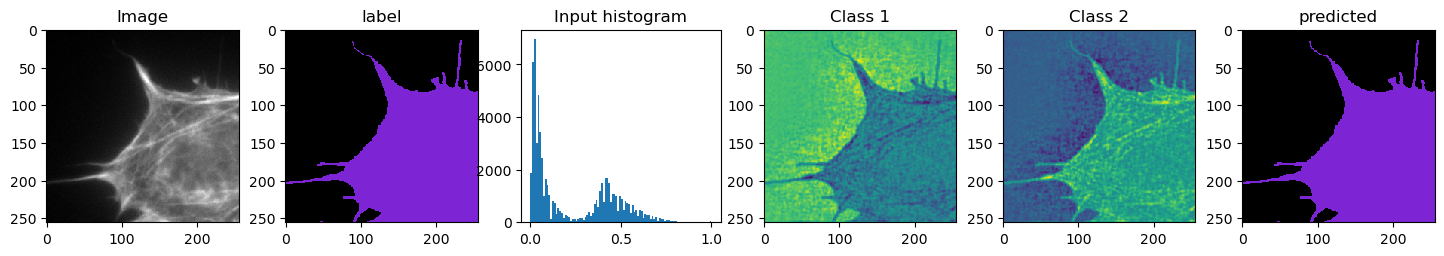

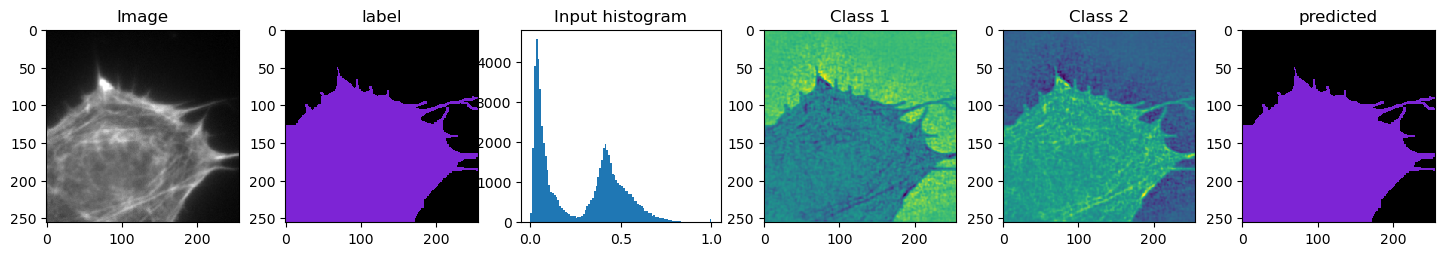

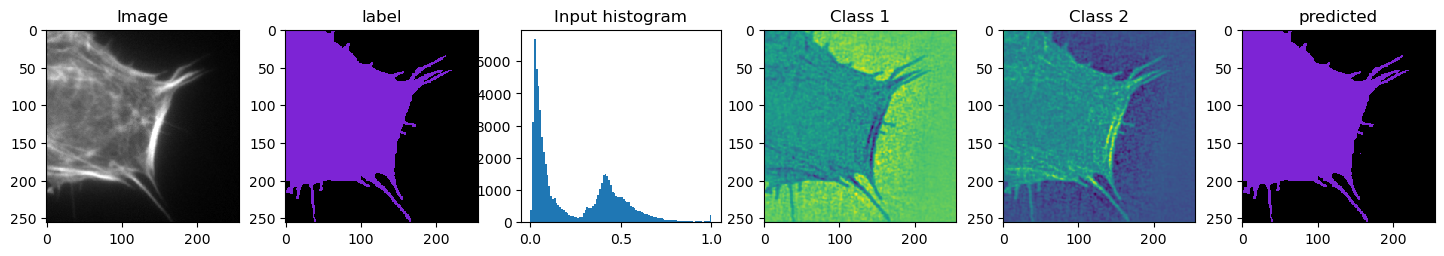

: 

In [ ]:

import torch.nn.functional as F

rlcm = random_label_cmap()

for i in range(3):
    #features, label = train_loader.dataset[random.randrange(len(train_loader.dataset))]
    features, label = check_loader.dataset[i]
    
    print('features min max', features.shape, features.min(), features.max(), features.mean(), features.dtype)

    hist_= np.histogram(features, bins=256)

    net.eval()
    features_tensor = torch.from_numpy(features).unsqueeze(0).to(device)       
    #features = features.todevice()
    predicted = net(features_tensor)

    features = np.transpose(features, (1,2,0))

    predicted.shape
    c1 = predicted[0,0,:,:].cpu().detach().numpy()
    c2 = predicted[0,1,:,:].cpu().detach().numpy()

    # Apply softmax along the class dimension (dim=1)
    probabilities = F.softmax(predicted, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1).cpu().detach().numpy()

    plot_types = 6*['imshow']
    plot_types[2] = 'hist'
    
    fig = imshow_multi2d([features, label, features, c1, c2, predicted_classes], ['Image', 'label', 'Input histogram', 'Class 1', 'Class 2', 'predicted'], 1, 6, 18, 2.5,
                         colormaps=['gray', rlcm, 'gray', 'viridis', 'viridis', rlcm], plottypes=plot_types)

In [18]:

viewer.add_image(c1, name='c1')
viewer.add_image(c2, name='c2')
viewer.add_labels(label, name='label')
viewer.add_labels(predicted_classes, name='predicted')  

<Labels layer 'predicted' at 0x15adcf79690>